In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import expipe
import pathlib
import numpy as np
import spatial_maps.stats as stats
import septum_mec
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
import head_direction.head as head
import spatial_maps as sp
import speed_cells.speed as spd
import re
import joblib
import multiprocessing
import shutil
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import statsmodels
import seaborn as sns
from distutils.dir_util import copy_tree
from neo import SpikeTrain
import scipy
from functools import reduce
from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()


from spike_statistics.core import permutation_resampling_test, block_bootstrap

from spikewaveform.core import calculate_waveform_features_from_template, cluster_waveform_features

from septum_mec.analysis.plotting import violinplot, despine

20:07:08 [I] klustakwik KlustaKwik2 version 0.2.6


In [3]:
%matplotlib inline
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (8, 4), 
    'figure.dpi': 150
})

output_path = pathlib.Path("output") / ("theta-rhythmicity")
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)
output_path.mkdir(exist_ok=True)

In [4]:
data_loader = dp.Data()
actions = data_loader.actions
project = data_loader.project

In [5]:
identification_action = actions['identify-neurons']
sessions = pd.read_csv(identification_action.data_path('sessions'))
units = pd.read_csv(identification_action.data_path('units'))
session_units = pd.merge(sessions, units, on='action')

In [6]:
theta_action = actions['theta-rhytmicity']
theta_results = pd.read_csv(theta_action.data_path('results'))

In [7]:
stim_action = actions['stimulus-response']
stim_results = pd.read_csv(stim_action.data_path('results'))

In [8]:
statistics_action = actions['calculate-statistics']
shuffling = actions['shuffling']

statistics_results = pd.read_csv(statistics_action.data_path('results'))
statistics_results = session_units.merge(statistics_results, how='left')
quantiles_95 = pd.read_csv(shuffling.data_path('quantiles_95'))
action_columns = ['action', 'channel_group', 'unit_name']
data = pd.merge(statistics_results, quantiles_95, on=action_columns, suffixes=("", "_threshold"))

In [9]:
data['unit_day'] = data.apply(lambda x: str(x.unit_idnum) + '_' + x.action.split('-')[1], axis=1)

In [10]:
data = data.merge(theta_results, how='left')

In [11]:
data = data.merge(stim_results, how='left')

In [12]:
waveform_action = actions['waveform-analysis']
waveform_results = pd.read_csv(waveform_action.data_path('results')).drop('template', axis=1)

In [13]:
data = data.merge(waveform_results, how='left')

In [14]:
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a']
labels = ['Baseline I', '11 Hz', 'Baseline II', '30 Hz']
queries = ['baseline and i and Hz11', 'frequency==11', 'baseline and ii and Hz30', 'frequency==30']

In [15]:
data.bs = data.bs.astype(bool)

In [16]:
data.loc[data.eval('t_i_peak == t_i_peak and not bs'), 'ns_inhibited'] = True
data.ns_inhibited.fillna(False, inplace=True)

data.loc[data.eval('t_i_peak != t_i_peak and not bs'), 'ns_not_inhibited'] = True
data.ns_not_inhibited.fillna(False, inplace=True)

In [17]:
# make baseline for inhibited vs not inhibited
data.loc[data.unit_id.isin(data.query('ns_inhibited').unit_id.values), 'ns_inhibited'] = True
data.loc[data.unit_id.isin(data.query('ns_not_inhibited').unit_id.values), 'ns_not_inhibited'] = True

In [18]:
query = (
    'gridness > gridness_threshold and '
    'information_rate > information_rate_threshold and '
    'gridness > .2 and '
    'average_rate < 25'
)
sessions_above_threshold = data.query(query)
print("Number of sessions above threshold", len(sessions_above_threshold))
print("Number of animals", len(sessions_above_threshold.groupby(['entity'])))

Number of sessions above threshold 194
Number of animals 4


In [19]:
gridcell_sessions = data[data.unit_day.isin(sessions_above_threshold.unit_day.values)]
print("Number of gridcells", gridcell_sessions.unit_idnum.nunique())
print("Number of gridcell recordings", len(gridcell_sessions))
print("Number of animals", len(gridcell_sessions.groupby(['entity'])))

Number of gridcells 139
Number of gridcell recordings 230
Number of animals 4


In [20]:
gridcell_sessions

,action,baseline,entity,frequency,i,ii,session,stim_location,stimulated,tag,...,t_i_peak,p_i_peak,half_width,peak_to_trough,average_firing_rate,bs,bs_stim,bs_ctrl,ns_inhibited,ns_not_inhibited
14,1839-120619-4,False,1839,30.0,False,True,4,ms,True,stim ii,...,0.0087,0.000055,0.259757,0.362390,0.180529,False,0.0,NaN,True,False
21,1839-120619-4,False,1839,30.0,False,True,4,ms,True,stim ii,...,0.0008,0.000880,0.242524,0.534827,2.265039,True,1.0,NaN,False,False
29,1839-120619-4,False,1839,30.0,False,True,4,ms,True,stim ii,...,NaN,NaN,0.279806,0.598967,10.924422,True,1.0,NaN,False,False
30,1839-120619-4,False,1839,30.0,False,True,4,ms,True,stim ii,...,0.0005,0.002365,0.265158,0.581451,3.984881,True,1.0,NaN,False,False
31,1839-120619-4,False,1839,30.0,False,True,4,ms,True,stim ii,...,NaN,NaN,0.246920,0.570844,3.497452,True,1.0,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1263,1833-010719-2,False,1833,11.0,True,False,2,ms,True,stim i,...,NaN,NaN,0.280033,0.560729,4.760330,True,1.0,NaN,False,False
1264,1833-010719-2,False,1833,11.0,True,False,2,ms,True,stim i,...,NaN,NaN,0.281934,0.627089,15.890929,True,1.0,NaN,False,False
1268,1833-010719-2,False,1833,11.0,True,False,2,ms,True,stim i,...,NaN,NaN,0.266512,0.594033,2.704037,True,1.0,NaN,False,False
1271,1833-010719-2,False,1833,11.0,True,False,2,ms,True,stim i,...,NaN,NaN,0.223261,0.592553,9.658453,True,1.0,NaN,False,False


In [21]:
data.loc[:,'gridcell'] = np.nan
data['gridcell'] = data.isin(gridcell_sessions)

data.loc[data.eval('not gridcell and bs'), 'bs_not_gridcell'] = True
data.bs_not_gridcell.fillna(False, inplace=True)

In [22]:
data.query('baseline and Hz11 and gridcell').head()

,action,baseline,entity,frequency,i,ii,session,stim_location,stimulated,tag,...,half_width,peak_to_trough,average_firing_rate,bs,bs_stim,bs_ctrl,ns_inhibited,ns_not_inhibited,gridcell,bs_not_gridcell
33,1833-260619-1,True,1833,NaN,True,False,1,NaN,False,baseline i,...,0.272875,0.602667,5.945508,True,NaN,1.0,False,False,True,False
34,1833-260619-1,True,1833,NaN,True,False,1,NaN,False,baseline i,...,0.226452,0.274814,2.860048,False,NaN,0.0,False,True,True,False
35,1833-260619-1,True,1833,NaN,True,False,1,NaN,False,baseline i,...,0.247266,0.570104,3.365674,True,NaN,1.0,False,False,True,False
39,1833-260619-1,True,1833,NaN,True,False,1,NaN,False,baseline i,...,0.284542,0.644111,17.471520,True,NaN,1.0,False,False,True,False
40,1833-260619-1,True,1833,NaN,True,False,1,NaN,False,baseline i,...,0.259920,0.581698,5.891739,True,NaN,1.0,False,False,True,False


In [23]:
keys = [
    'theta_score',
    'theta_bandpower',
    'theta_relpower',
    'theta_relpeak',
    'theta_peak',
    'theta_freq',
    'theta_half_width',
    'stim_bandpower',
    'stim_relpower',
    'stim_relpeak',
    'stim_half_width',
    'stim_p_max',
    'stim_strength',
]
cell_types = [
    'gridcell', 
    'ns_inhibited', 
    'ns_not_inhibited'
]
results = {}
for cell_type in cell_types:
    results[cell_type] = {}
    for key in keys:
        results[cell_type][key] = list()
        for query, label in zip(queries, labels):
            values = data.query(query + ' and ' + cell_type).loc[:,['entity', 'unit_idnum', 'date', key]]
            results[cell_type][key].append(values.rename({key: label}, axis=1))

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [24]:
for cell_type, cell_type_val in results.items():
    for key, val in cell_type_val.items():
        df = reduce(lambda  left, right: pd.merge(left, right, on=['entity', 'unit_idnum', 'date'], how='outer'), val)
        results[cell_type][key] = df#.drop('unit_day',axis=1)

In [25]:
results['gridcell']['theta_relpeak']

,entity,unit_idnum,date,Baseline I,11 Hz,Baseline II,30 Hz
0,1833,30,260619,NaN,NaN,NaN,NaN
1,1833,31,260619,NaN,NaN,NaN,0.076589
2,1833,32,260619,NaN,0.025278,NaN,0.171169
3,1833,78,260619,NaN,NaN,NaN,NaN
4,1833,79,260619,NaN,0.120941,NaN,NaN
...,...,...,...,...,...,...,...
146,1833,249,120619,NaN,NaN,NaN,0.085165
147,1833,218,290519,NaN,NaN,NaN,0.123051
148,1833,106,60619,NaN,NaN,NaN,0.302206
149,1833,168,60619,NaN,NaN,NaN,0.123118


In [26]:
def drop_duplicates_least_null(df, key):
    return df.loc[df.notnull().sum(1).groupby(df[key]).idxmax()]

In [27]:
for cell_type, val in results.items():
    for key, df in val.items():
        results[cell_type][key] = drop_duplicates_least_null(df, 'unit_idnum')

In [28]:
results['gridcell']['theta_score']

,entity,unit_idnum,date,Baseline I,11 Hz,Baseline II,30 Hz
51,1833,8,20719,0.032888,NaN,NaN,NaN
86,1833,13,20719,NaN,0.036234,0.070053,0.040333
87,1833,14,20719,NaN,0.026389,0.065223,NaN
58,1833,23,200619,0.024479,NaN,NaN,NaN
128,1833,26,200619,NaN,NaN,0.043209,-0.001775
...,...,...,...,...,...,...,...
140,1849,835,150319,NaN,NaN,NaN,0.126066
43,1849,851,60319,0.104610,NaN,NaN,NaN
65,1849,932,280219,0.124715,NaN,NaN,NaN
74,1849,937,280219,NaN,-0.015202,NaN,NaN


/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-pac

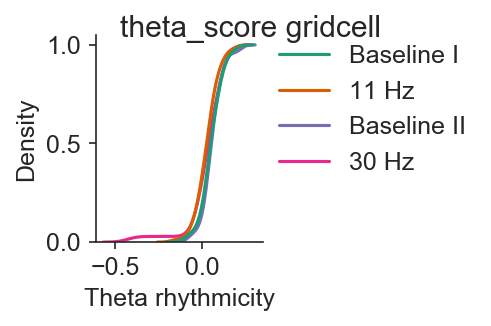

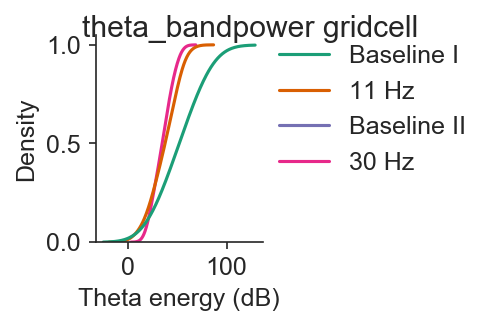

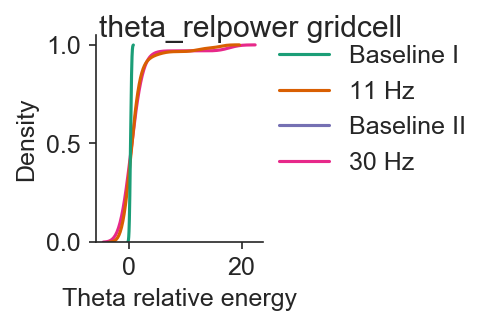

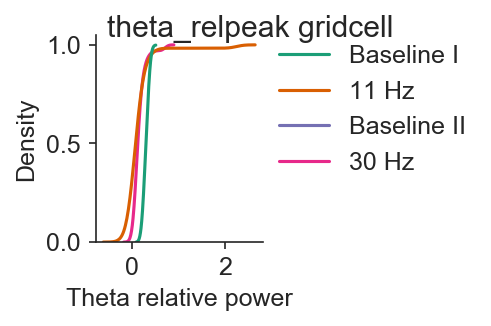

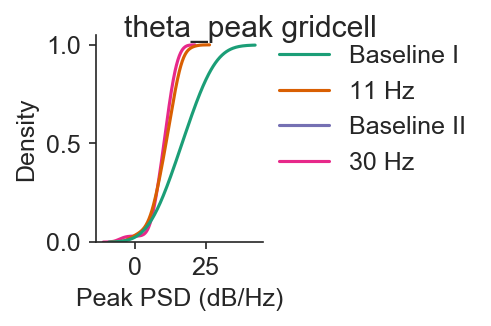

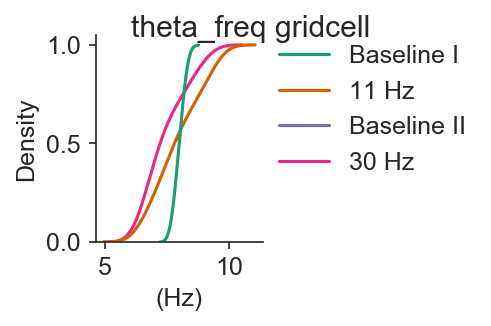

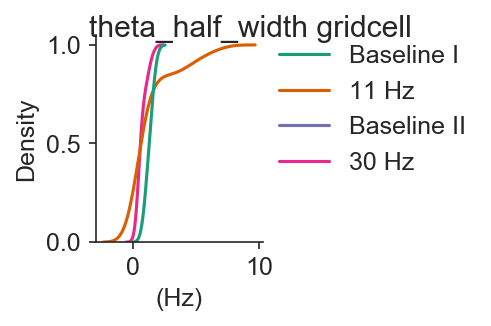

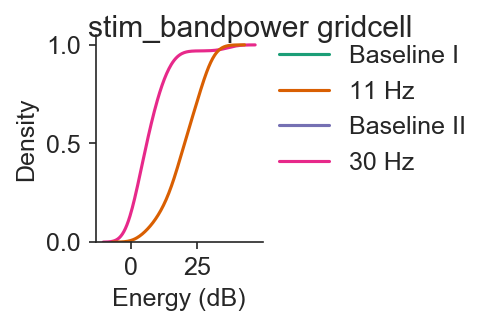

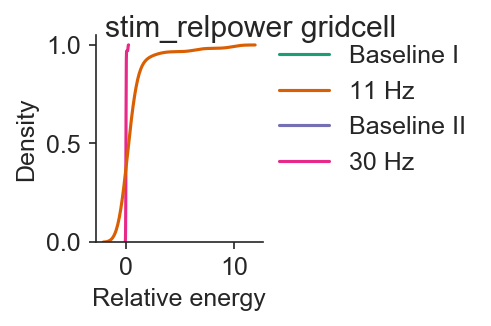

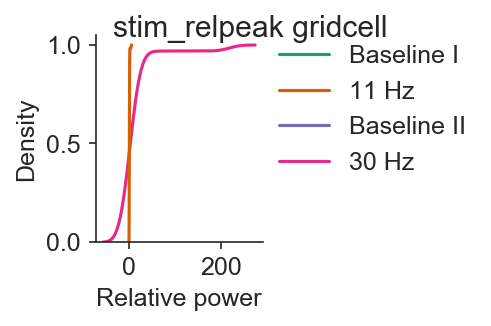

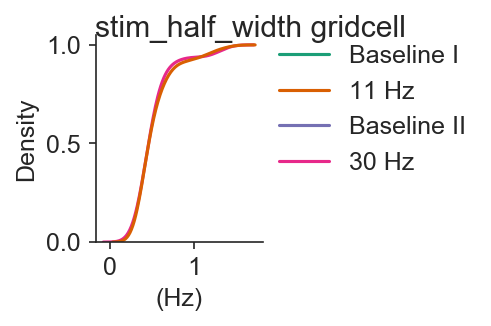

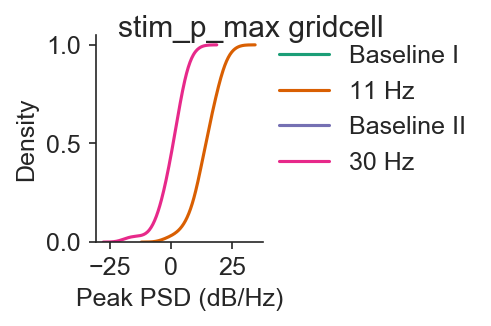

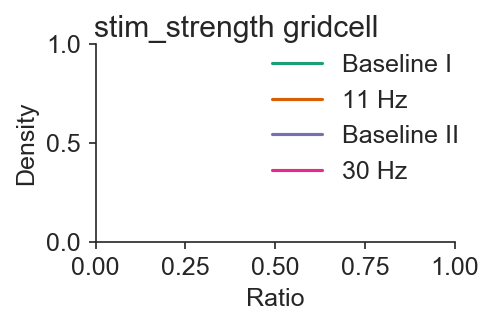

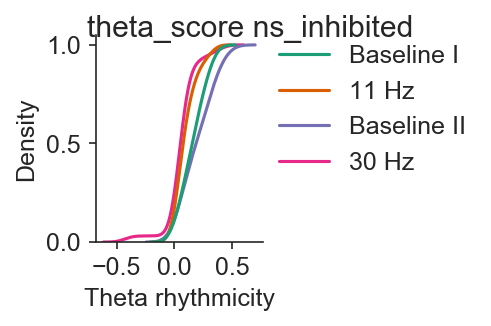

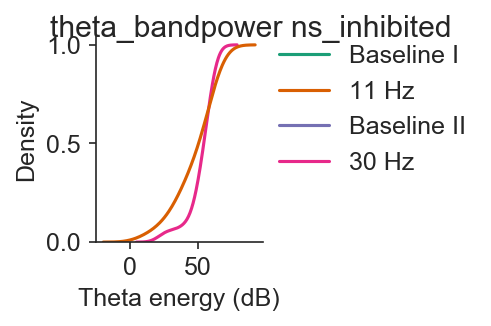

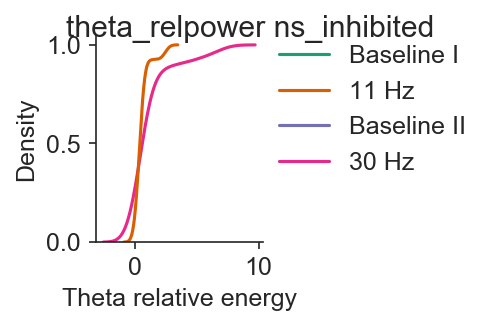

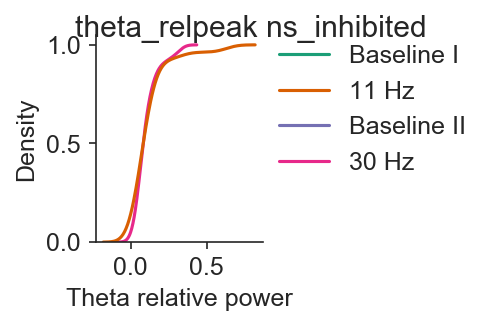

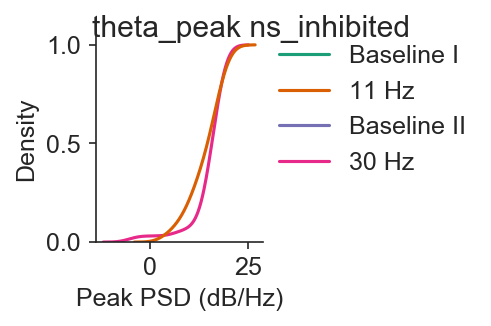

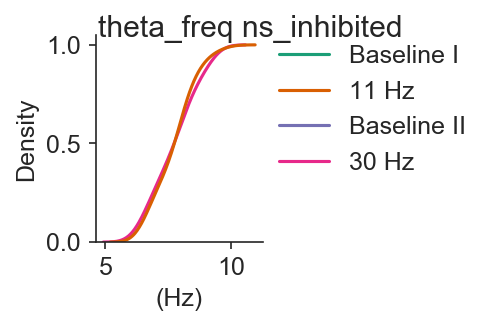

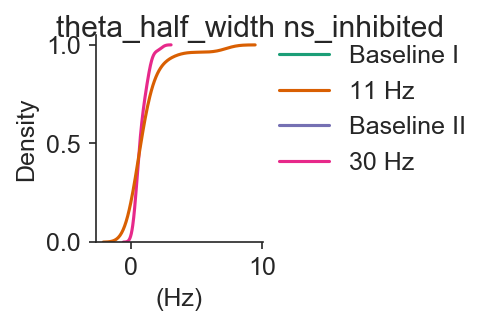

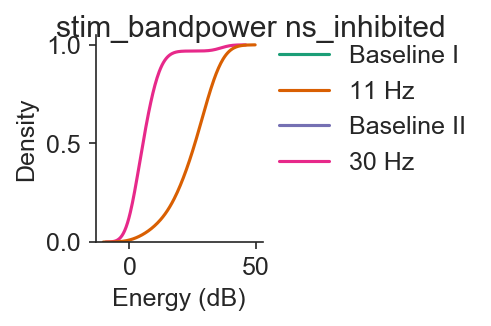

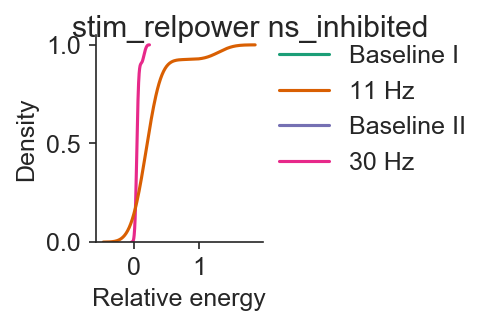

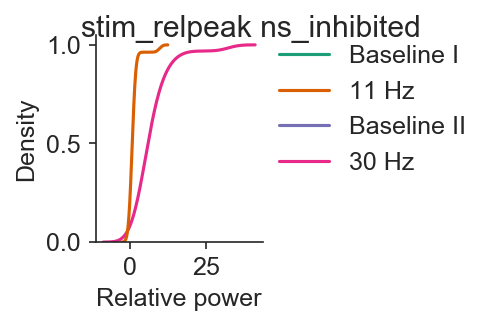

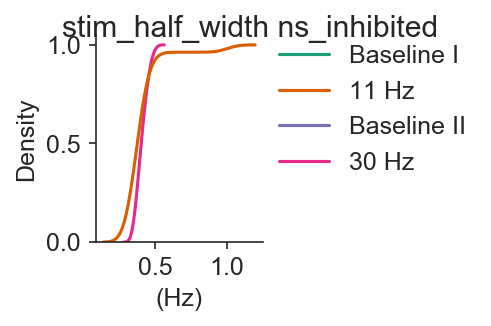

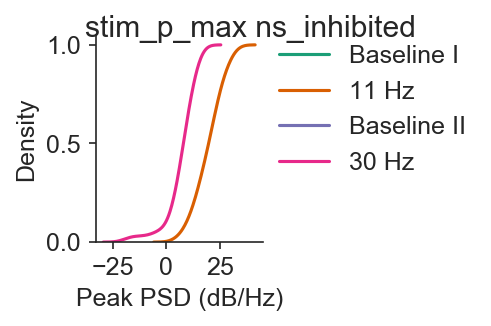

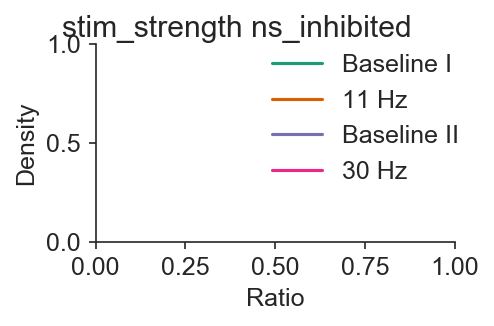

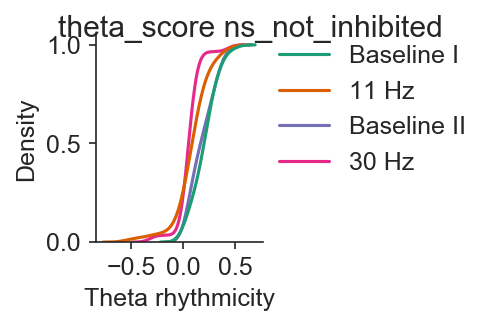

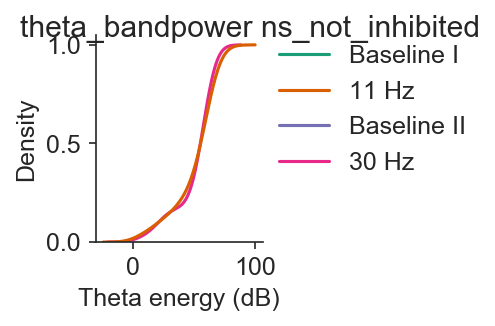

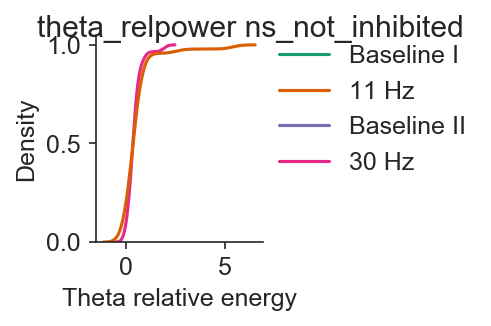

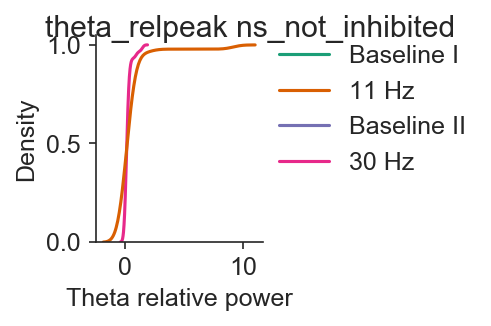

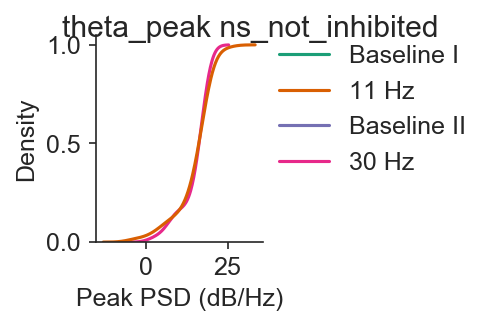

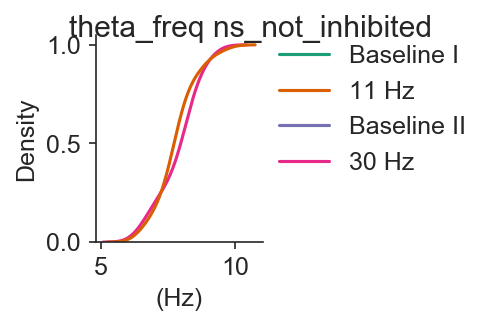

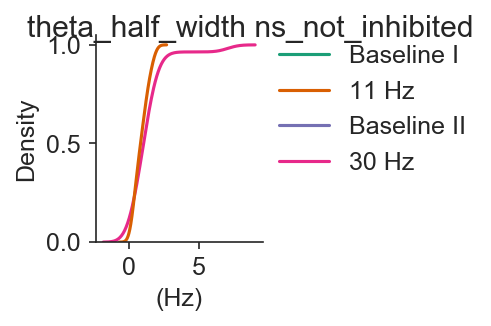

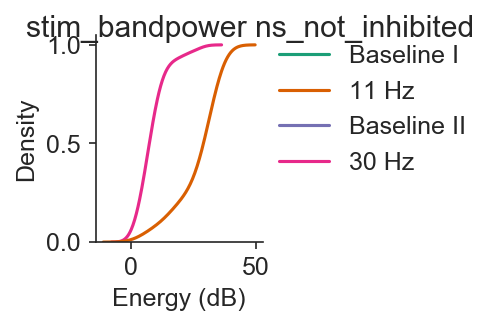

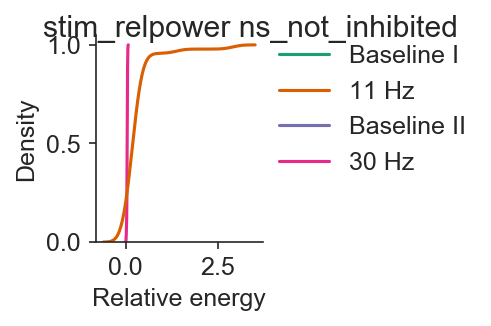

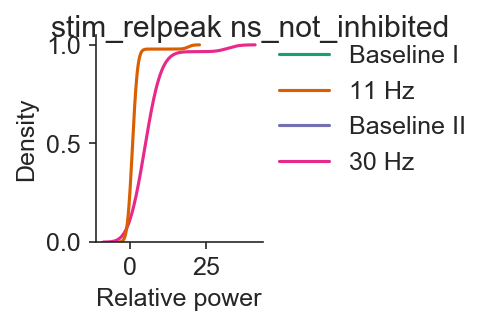

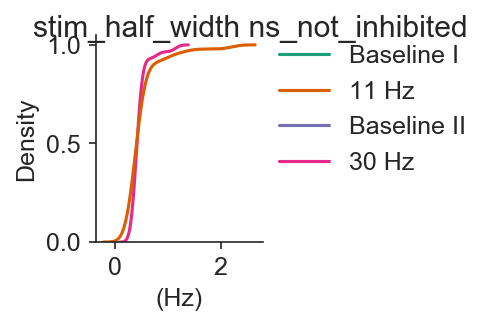

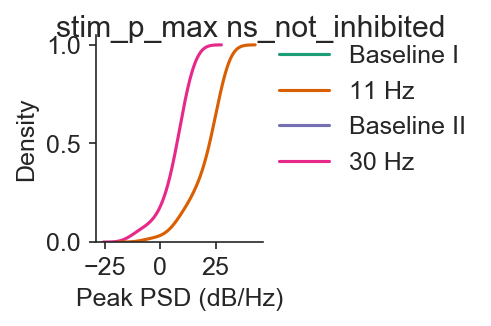

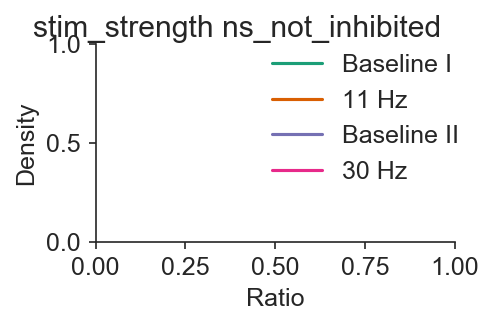

In [29]:
xlabel = {
    'theta_score': 'Theta rhythmicity',
    'theta_bandpower': 'Theta energy (dB)',
    'theta_relpower': 'Theta relative energy',
    'theta_relpeak': 'Theta relative power',
    'theta_peak': 'Peak PSD (dB/Hz)',
    'theta_freq': '(Hz)',
    'theta_half_width': '(Hz)',
    'stim_bandpower': 'Energy (dB)',
    'stim_relpower': 'Relative energy',
    'stim_relpeak': 'Relative power',
    'stim_half_width': '(Hz)',
    'stim_p_max': 'Peak PSD (dB/Hz)',
    'stim_strength': 'Ratio',
}
for cell_type in ['gridcell', 'ns_inhibited', 'ns_not_inhibited']:
    for key in keys:
        fig = plt.figure(figsize=(3.5,2.2))
        plt.suptitle(key + ' ' + cell_type)
        legend_lines = []
        for color, label in zip(colors, labels):
            legend_lines.append(matplotlib.lines.Line2D([0], [0], color=color, label=label))
        sns.kdeplot(data=results[cell_type][key].loc[:,labels], cumulative=True, legend=False, palette=colors, common_norm=False)
        plt.xlabel(xlabel[key])
        plt.legend(
            handles=legend_lines,
            bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
        plt.tight_layout()
        plt.grid(False)
#         plt.xlim(-0.05, bins[key].max() - bins[key].max()*0.02)
        despine()
        figname = f'theta-rhythmicity-{key}-{cell_type}'.replace(' ', '-')
        fig.savefig(
            output_path / 'figures' / f'{figname}.png', 
            bbox_inches='tight', transparent=True)
        fig.savefig(
            output_path / 'figures' / f'{figname}.svg', 
            bbox_inches='tight', transparent=True)

# stats

In [30]:
bootstrap_results = {}
for cell_type in results:
    bootstrap_results[cell_type] = {}
    for key, df in results[cell_type].items():
        bootstrap_results[cell_type][key] = pd.DataFrame()
        group = df.groupby('entity')
        for label in labels:
            entity_values = np.array([d.loc[:, label].dropna().values for _, d in group if d.loc[:, label].count() > 0])
            if len([i for j in entity_values for i in j]) < 3: # less than total 3 samples
                boot_samples = np.ones(100) * np.nan
            else:
                boot_samples = block_bootstrap(entity_values, n_boots=100, n_samples=10, n_blocks=4, statistic=np.mean)
            bootstrap_results[cell_type][key].loc[:, label] = np.ravel(boot_samples)

In [31]:
bootstrap_results['gridcell']['theta_score']

,Baseline I,11 Hz,Baseline II,30 Hz
0,0.078145,0.045643,0.159844,0.046290
1,0.055192,0.016396,0.085040,0.045542
2,0.048768,0.027872,0.088509,0.004318
3,0.060329,0.013847,0.104013,0.025301
4,0.076312,0.015210,0.091315,0.056712
...,...,...,...,...
95,0.056592,0.027097,0.115400,0.045428
96,0.065034,0.025985,0.089597,0.052725
97,0.064693,0.026460,0.145398,0.051633
98,0.065068,0.029983,0.105945,0.022066


In [32]:
def compute_weighted_mean_sem(data, label):
    group = data.groupby('entity')
    tmp = [d.loc[:, label].dropna().values for _, d in group]
    values = np.concatenate(tmp)
    if len(values) == 0:
        return [np.nan] * 3
    weights = np.concatenate([np.ones_like(a) / len(a) for a in tmp])
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values - average)**2, weights=weights)
    sem = np.sqrt(variance / len(values))
    return average, sem, len(values)


def compute_confidence_interval(data, alpha=0.05):
    stat = np.sort(data.dropna())
    n = len(stat)
    if n == 0:
        return np.nan, np.nan
    low = stat[int((alpha / 2.0) * n)]
    high = stat[int((1 - alpha / 2.0) * n)]
#     low, high = np.percentile(data.dropna(), [(alpha / 2.0) * 100, (1 - alpha / 2.0) * 100])
    return low, high


def pvalue(df, df_bootstrap, control_key, case_key):
    '''
    pvalue
    '''
    case, b = df_bootstrap[case_key].dropna(), df_bootstrap[control_key].dropna()
    if len(case) == 0 or len(b) == 0:
        return np.nan
    
    n = len(case)
    
    average_case, _, _ = compute_weighted_mean_sem(df, case_key)
    average_control, _, _ = compute_weighted_mean_sem(df, control_key)
    
    low, high = compute_confidence_interval(case - average_control)
    
    case_shift = case - case.mean()
    diff = abs(average_case - average_control)    
    
    pval = (np.sum(case_shift > diff) + np.sum(case_shift < - diff)) / n
    
    return "{:.1e} [{:.2f}, {:.2f}]".format(pval, low, high)


def rename(name):
    return name.replace("_field", "-field").replace("_", " ").capitalize()

In [33]:
stats = {}
for cell_type in bootstrap_results:
    stat = pd.DataFrame()

    for key, df in bootstrap_results[cell_type].items():
        Key = rename(key)
        
        for label in labels:
#             low, high = compute_confidence_interval(df.loc[:,label])
#             average, _, n = compute_weighted_mean_sem(results[cell_type][key], label)
#             stat.loc[label, Key] = "{:.2f} [{:.2f}, {:.2f}] ({})".format(average, low, high, n)
            average, sem, n = compute_weighted_mean_sem(results[cell_type][key], label)
            if np.isnan(average):
                stat.loc[label, Key] = np.nan
            else:
                stat.loc[label, Key] = "{:.2f} ± {:.2f} ({})".format(average, sem, n)

        for i, c1 in enumerate(df.columns):
            for c2 in df.columns[i+1:]:
                stat.loc[f'{c1} - {c2}', Key] = pvalue(results[cell_type][key], df, c1, c2)

    stats[cell_type] = stat

In [34]:
stats['gridcell']

,Theta score,Theta bandpower,Theta relpower,Theta relpeak,Theta peak,Theta freq,Theta half width,Stim bandpower,Stim relpower,Stim relpeak,Stim half width,Stim p max,Stim strength
Baseline I,0.06 ± 0.01 (63),51.92 ± 11.61 (2),0.27 ± 0.08 (2),0.29 ± 0.03 (2),16.65 ± 3.89 (2),8.00 ± 0.12 (2),1.25 ± 0.19 (2),NaN,NaN,NaN,NaN,NaN,NaN
11 Hz,0.02 ± 0.01 (57),38.98 ± 2.16 (59),0.79 ± 0.24 (59),0.16 ± 0.05 (59),11.46 ± 0.61 (59),7.64 ± 0.12 (59),0.93 ± 0.17 (59),20.52 ± 1.10 (59),0.43 ± 0.14 (59),0.77 ± 0.09 (59),0.50 ± 0.03 (59),15.09 ± 0.85 (59),NaN
Baseline II,0.10 ± 0.01 (46),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30 Hz,0.04 ± 0.02 (35),36.92 ± 1.77 (33),0.66 ± 0.33 (33),0.19 ± 0.04 (33),10.53 ± 0.78 (33),7.30 ± 0.16 (33),0.71 ± 0.09 (32),7.89 ± 1.36 (33),0.04 ± 0.00 (33),20.29 ± 10.43 (33),0.49 ± 0.03 (32),0.46 ± 1.15 (33),NaN
Baseline I - 11 Hz,"1.0e-02 [-0.07, -0.02]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Baseline I - Baseline II,"5.0e-01 [-0.02, 0.13]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Baseline I - 30 Hz,"1.4e-01 [-0.11, 0.00]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11 Hz - Baseline II,"5.0e-02 [0.01, 0.17]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11 Hz - 30 Hz,"5.5e-01 [-0.07, 0.04]","5.5e-01 [-10.75, 4.84]","8.0e-01 [-0.49, 0.91]","6.6e-01 [-0.05, 0.16]","5.3e-01 [-4.60, 1.44]","1.2e-01 [-0.80, -0.02]","1.0e-01 [-0.40, 0.08]","0.0e+00 [-15.37, -7.63]","0.0e+00 [-0.40, -0.37]","3.6e-01 [0.24, 61.46]","6.9e-01 [-0.09, 0.06]","0.0e+00 [-17.58, -11.30]",NaN
Baseline II - 30 Hz,"3.0e-02 [-0.14, -0.03]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
for cell_type, stat in stats.items():
    stat.to_latex(output_path / "statistics" / f"statistics_{cell_type}.tex")
    stat.to_csv(output_path / "statistics" / f"statistics_{cell_type}.csv")

## paired stats

In [36]:
def wilcoxon(df, keys):
    dff = df.loc[:,[keys[0], keys[1]]].dropna()
    statistic, pvalue = scipy.stats.wilcoxon(
        dff[keys[0]], 
        dff[keys[1]],
        alternative='two-sided')

#     return "{:.2f}, {:.2f}, {:.2f}, {:.1e}, ({})".format(dff[keys[0]].mean(), dff[keys[1]].mean(), statistic, pvalue, len(dff))
    return "{:.2f}, {:.1e}, ({})".format(statistic, pvalue, len(dff))
#     return pvalue

# def summarize_paired(df, keys):
#     dff = df.loc[:,[keys[0], keys[1]]].dropna()

#     return dff[keys[0]].mean(), dff[keys[0]].sem(), dff[keys[1]].mean(), dff[keys[1]].sem(), len(dff)


def MWU(df, keys):
    '''
    Mann Whitney U
    '''
    d1 = df[keys[0]].dropna()
    d2 = df[keys[1]].dropna()
    Uvalue, pvalue = scipy.stats.mannwhitneyu(
        d1, d2, alternative='two-sided')

#     return"{:.2f}, {:.2f}, {:.0f}, {:.1e}, ({}), ({})".format(d1.mean(), d2.mean(), Uvalue, pvalue, len(d1), len(d2))
#     return"{:.0f}, {:.1e}".format(Uvalue, pvalue)
    return pvalue

    
def normality(df, key):
    statistic, pvalue = scipy.stats.normaltest(
        df[key].dropna())

    return "{:.2f}, {:.1e}".format(statistic, pvalue)

In [37]:
paired_stats = {}
for cell_type, cell_results in results.items():
    paired_stat = pd.DataFrame()

    for key, df in cell_results.items():
        Key = rename(key)

#         for i, c1 in enumerate(labels):
#             for c2 in labels[i+1:]:
#                 m1, s1, m2, s2, n = summarize_paired(df, [c1, c2])
#                 paired_stat.loc[f'{c1}', Key] = "{:.2f} ± {:.2f} ({})".format(m1, s1, n)
#                 paired_stat.loc[f'{c2}', Key] = "{:.2f} ± {:.2f} ({})".format(m2, s2, n)

        for label in labels:
            norm = normality(df, label) if df[label].count() >= 8 else np.nan
            paired_stat.loc[f'Normality {label}', Key] = norm

        for i, c1 in enumerate(labels):
            for c2 in labels[i+1:]:
    #             paired_stat.loc[f'{c1} - {c2}', Key] = wilcoxon(df, [c1, c2])
                try:
                    paired_stat.loc[f'Wilcoxon {c1} - {c2}', Key] = wilcoxon(df, [c1, c2])
                except:
                    paired_stat.loc[f'Wilcoxon {c1} - {c2}', Key] = np.nan
    #             paired_stat.loc[f'MWU {c1} - {c2}', Key] = MWU(df, [c1, c2])
    paired_stats[cell_type] = paired_stat

paired_stat

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/scipy/stats/morestats.py:2863: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


,Theta score,Theta bandpower,Theta relpower,Theta relpeak,Theta peak,Theta freq,Theta half width,Stim bandpower,Stim relpower,Stim relpeak,Stim half width,Stim p max,Stim strength
Normality Baseline I,"0.13, 9.4e-01",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Normality 11 Hz,"20.12, 4.3e-05","15.14, 5.2e-04","87.48, 1.0e-19","101.03, 1.2e-22","24.02, 6.1e-06","2.19, 3.3e-01","5.80, 5.5e-02","12.08, 2.4e-03","87.80, 8.6e-20","103.36, 3.6e-23","71.63, 2.8e-16","12.05, 2.4e-03",NaN
Normality Baseline II,"6.12, 4.7e-02",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Normality 30 Hz,"15.87, 3.6e-04","16.94, 2.1e-04","38.79, 3.8e-09","45.00, 1.7e-10","17.09, 1.9e-04","1.59, 4.5e-01","51.37, 7.0e-12","18.18, 1.1e-04","5.28, 7.1e-02","46.88, 6.6e-11","50.16, 1.3e-11","10.48, 5.3e-03",NaN
Wilcoxon Baseline I - 11 Hz,"15.00, 1.9e-02, (14)","0.00, 3.2e-01, (1)","0.00, 3.2e-01, (1)","0.00, 3.2e-01, (1)","0.00, 3.2e-01, (1)","0.00, 3.2e-01, (1)","0.00, 3.2e-01, (1)",NaN,NaN,NaN,NaN,NaN,NaN
Wilcoxon Baseline I - Baseline II,"31.00, 1.0e-01, (15)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wilcoxon Baseline I - 30 Hz,"3.00, 1.2e-03, (15)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wilcoxon 11 Hz - Baseline II,"10.00, 1.6e-03, (17)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wilcoxon 11 Hz - 30 Hz,"12.00, 6.2e-02, (11)","22.00, 3.3e-01, (11)","21.00, 2.9e-01, (11)","25.00, 4.8e-01, (11)","21.00, 2.9e-01, (11)","11.00, 1.7e-01, (11)","13.00, 7.5e-02, (11)","0.00, 3.3e-03, (11)","0.00, 3.3e-03, (11)","0.00, 3.3e-03, (11)","1.00, 4.4e-03, (11)","0.00, 3.3e-03, (11)",NaN
Wilcoxon Baseline II - 30 Hz,"7.00, 1.0e-04, (22)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
for cell_type, paired_stat in paired_stats.items():
    paired_stat.to_latex(output_path / "statistics" / f"paired-statistics_{cell_type}.tex")
    paired_stat.to_csv(output_path / "statistics" / f"paired-statistics_{cell_type}.csv")

In [39]:
for cell_type, cell_results in results.items():
    for key, result in cell_results.items():
        result.to_latex(output_path / "statistics" / f"values_{cell_type}_{key}.tex")
        result.to_csv(output_path / "statistics" / f"values_{cell_type}_{key}.csv")

# Store results in Expipe action

In [40]:
action = project.require_action("theta-rhythmicity")

In [41]:
copy_tree(output_path, str(action.data_path()))

['/media/storage/expipe/septum-mec/actions/theta-rhythmicity/data/statistics/values_gridcell_theta_freq.csv',
 '/media/storage/expipe/septum-mec/actions/theta-rhythmicity/data/statistics/values_ns_inhibited_theta_bandpower.tex',
 '/media/storage/expipe/septum-mec/actions/theta-rhythmicity/data/statistics/values_ns_inhibited_stim_bandpower.csv',
 '/media/storage/expipe/septum-mec/actions/theta-rhythmicity/data/statistics/values_gridcell_theta_freq.tex',
 '/media/storage/expipe/septum-mec/actions/theta-rhythmicity/data/statistics/paired-statistics_ns_not_inhibited.tex',
 '/media/storage/expipe/septum-mec/actions/theta-rhythmicity/data/statistics/values_gridcell_stim_relpeak.csv',
 '/media/storage/expipe/septum-mec/actions/theta-rhythmicity/data/statistics/values_ns_inhibited_theta_half_width.csv',
 '/media/storage/expipe/septum-mec/actions/theta-rhythmicity/data/statistics/values_gridcell_theta_relpower.tex',
 '/media/storage/expipe/septum-mec/actions/theta-rhythmicity/data/statistics/pa

In [42]:
septum_mec.analysis.registration.store_notebook(action, "20-theta-rhythmicity.ipynb")